# Import Libraries & Load Dataset

In [2]:
# Import library yang dibutuhkan
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path ke dataset
data_dir = '/kaggle/input/animals10/raw-img'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {data_dir}")

## Distribusi Sample Tiap Kelas

/tmp/ipykernel_35/3311459357.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min(len(x), 1400), random_state=42))


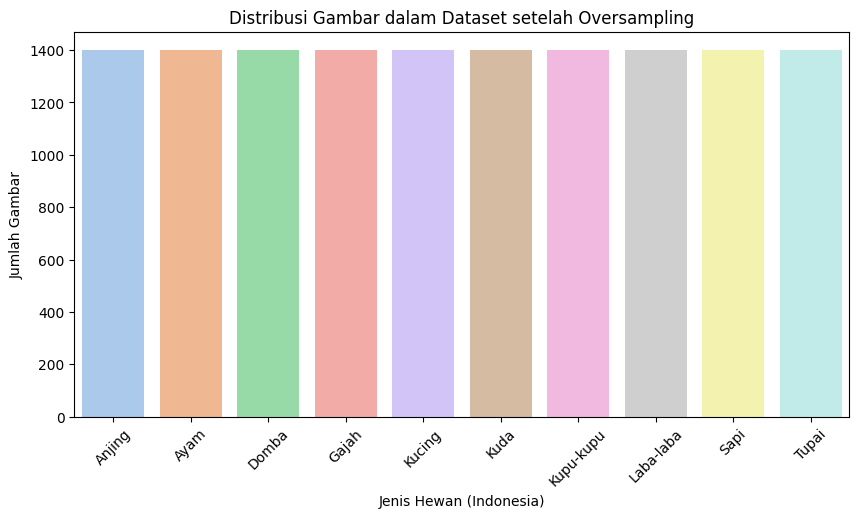

class
Anjing       1400
Ayam         1400
Domba        1400
Gajah        1400
Kucing       1400
Kuda         1400
Kupu-kupu    1400
Laba-laba    1400
Sapi         1400
Tupai        1400
Name: count, dtype: int64


In [3]:
# Terjemahan nama kelas dari Italia ke Indonesia
translate = {
    "cane": "Anjing",
    "gatto": "Kucing",
    "cavallo": "Kuda",
    "ragno": "Laba-laba",
    "farfalla": "Kupu-kupu",
    "gallina": "Ayam",
    "mucca": "Sapi",
    "elefante": "Gajah",
    "pecora": "Domba",
    "scoiattolo": "Tupai"
}

# Membaca semua data ke DataFrame
data = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        translated_class = translate.get(class_name.lower(), class_name)
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append([img_path, translated_class])

df = pd.DataFrame(data, columns=['path', 'class'])

# Sampling untuk keseimbangan data (maks 1400 gambar per kelas)
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min(len(x), 1400), random_state=42))

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
sns.countplot(data=df_balanced, x='class', palette="pastel")
plt.xticks(rotation=45)
plt.xlabel("Jenis Hewan (Indonesia)")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar dalam Dataset setelah Oversampling")
plt.show()

# Tampilkan jumlah gambar per kelas
print(df_balanced['class'].value_counts())

## Plot Gambar Sample dari Setiap Kelas dan Ukurannya

/tmp/ipykernel_35/4054159014.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42)[['path', 'class']])


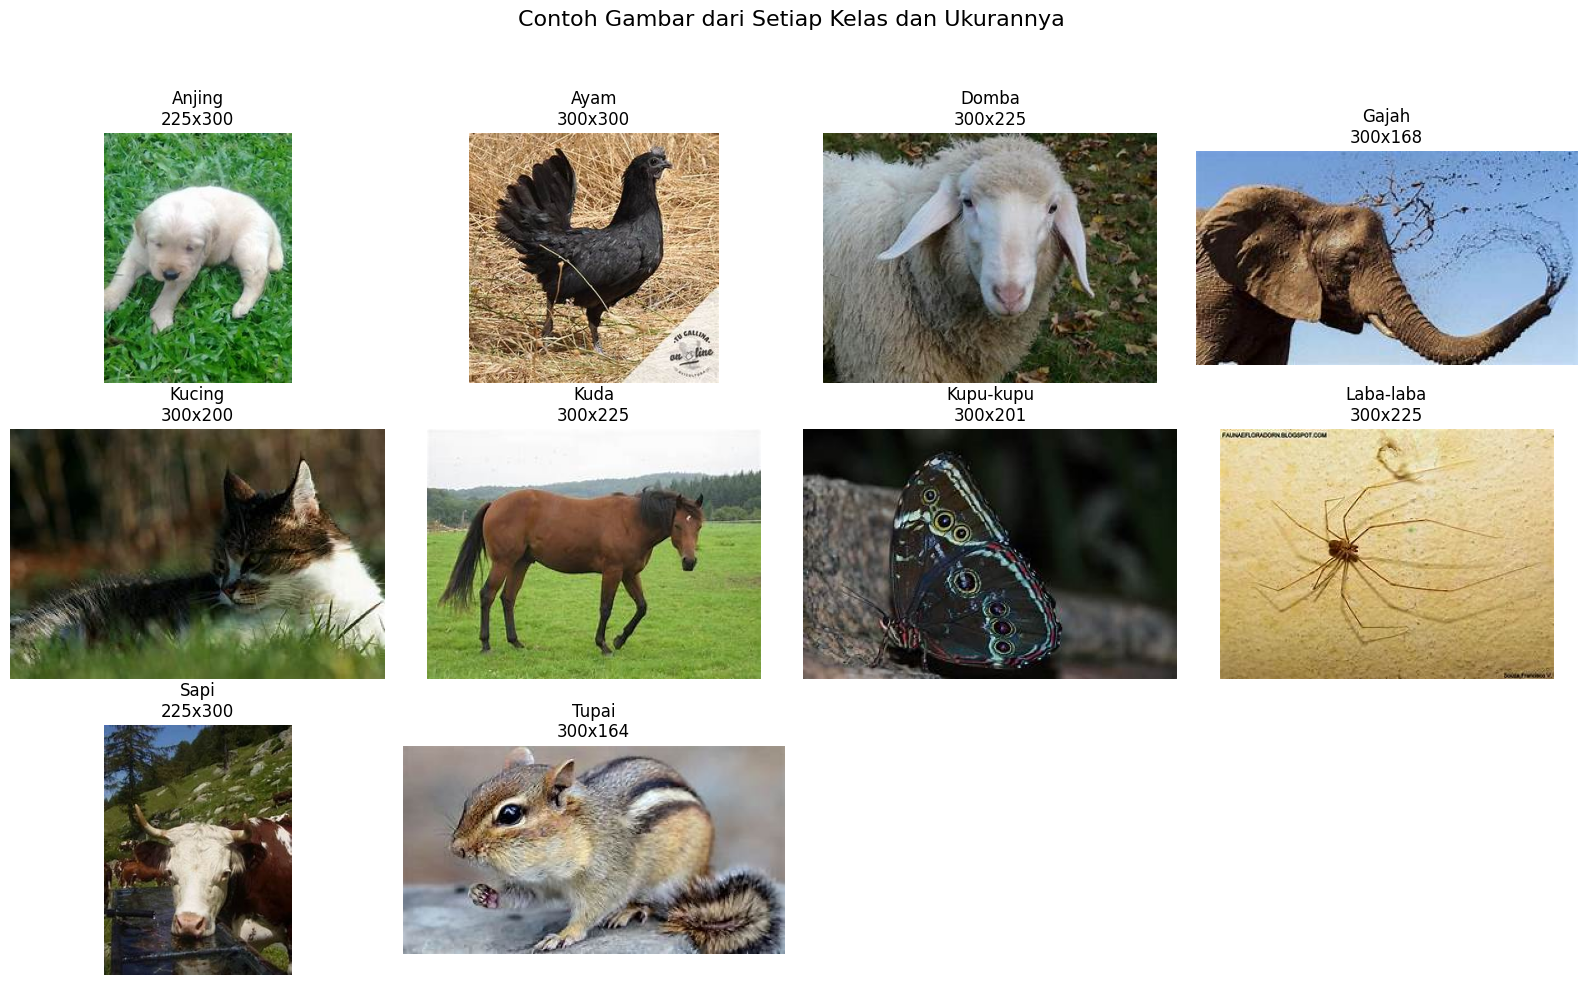

In [4]:
from PIL import Image

# Buat ulang sample_images: 1 gambar acak dari setiap kelas
sample_images = (
    df_balanced
    .groupby('class', group_keys=False)
    .apply(lambda x: x.sample(1, random_state=42)[['path', 'class']])
    .reset_index(drop=True)
)

# Plot
plt.figure(figsize=(16, 10))
for idx, (_, row) in enumerate(sample_images.iterrows()):
    try:
        img = Image.open(row['path'])
        width, height = img.size
        plt.subplot(3, 4, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{row['class']}\n{width}x{height}")
    except Exception as e:
        print(f"Error membuka gambar {row['path']}: {e}")

plt.suptitle("Contoh Gambar dari Setiap Kelas dan Ukurannya", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Split Dataset

In [5]:
from sklearn.model_selection import train_test_split

# 1. Split: train (70%) vs val+test (30%)
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.3,
    stratify=df_balanced['class'],
    random_state=42
)

# 2. Split: val (15%) vs test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class'],
    random_state=42
)

# 3. Tambahkan kolom 'split' agar bisa digabung
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# 4. Gabungkan semua ke satu DataFrame
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(df_all.groupby(['split', 'class']).size().unstack())


class  Anjing  Ayam  Domba  Gajah  Kucing  Kuda  Kupu-kupu  Laba-laba  Sapi  \
split                                                                         
test      210   210    210    210     210   210        210        210   210   
train     980   980    980    980     980   980        980        980   980   
val       210   210    210    210     210   210        210        210   210   

class  Tupai  
split         
test     210  
train    980  
val      210  


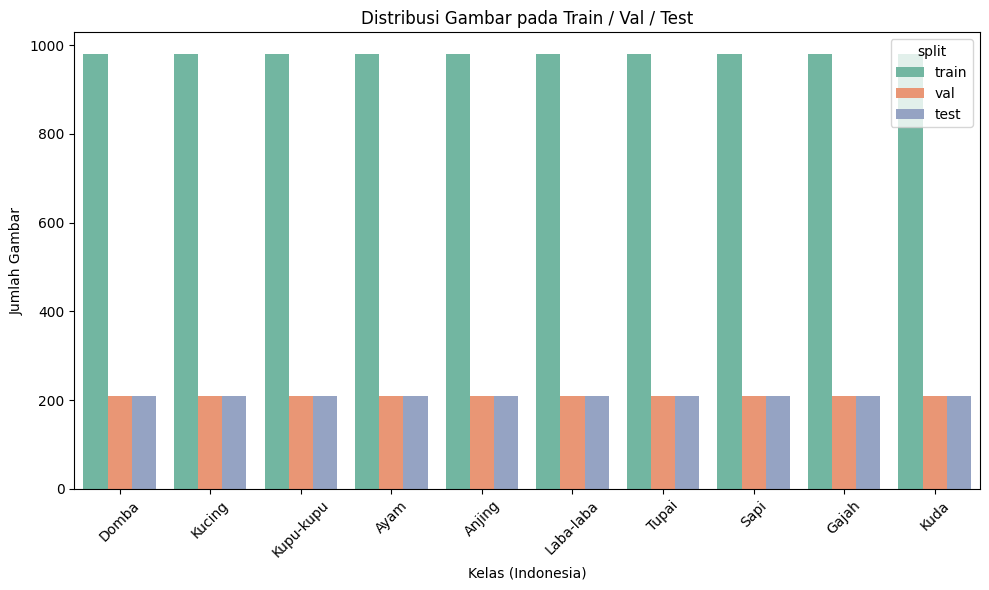

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_all, x='class', hue='split', palette='Set2')
plt.title("Distribusi Gambar pada Train / Val / Test")
plt.xlabel("Kelas (Indonesia)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ImageDataGenerator + Augmentasi

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Generator untuk data latih (augmentasi ringan)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Generator validasi & test tanpa augmentasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Parameter umum
target_size = (224, 224)
batch_size = 32
class_mode = 'categorical'
seed = 42

# 4. Dataset split
df_train = df_all[df_all['split'] == 'train']
df_val = df_all[df_all['split'] == 'val']
df_test = df_all[df_all['split'] == 'test']

# 5. Flow dari dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True,
    seed=seed
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

2025-06-17 09:08:24.907553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750151305.468560      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750151305.611038      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 9800 validated image filenames belonging to 10 classes.
Found 2100 validated image filenames belonging to 10 classes.
Found 2100 validated image filenames belonging to 10 classes.


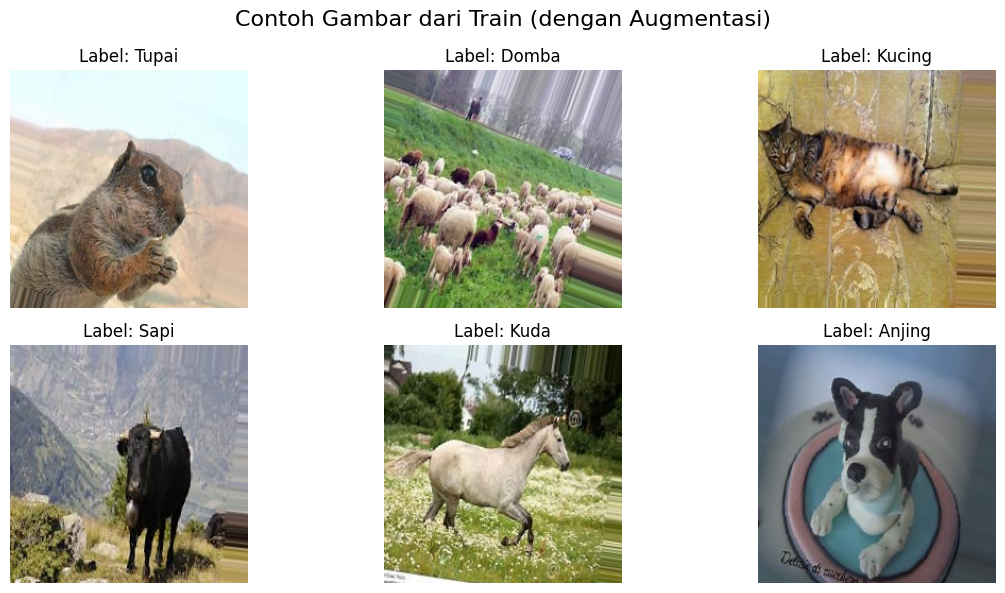

In [8]:
# Ambil 1 batch dari train_generator
images, labels = next(train_generator)

# Peta indeks ke nama kelas
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Tampilkan 6 gambar pertama dari batch
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    
    label_index = labels[i].argmax()
    label_name = idx_to_class[label_index]
    
    plt.title(f"Label: {label_name}")
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Train (dengan Augmentasi)", fontsize=16)
plt.tight_layout()
plt.show()

# Modeling - CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Arsitektur CNN mirip last_model
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Classifier
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 kelas Animals-10
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan arsitektur
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750151399.374344      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750151399.375136      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,940,618 (49.36 MB)

 Trainable params: 12,940,170 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

# Training Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750151581.510937     149 service.cc:148] XLA service 0x7cff600124b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750151581.512687     149 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750151581.512707     149 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750151582.145365     149 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/307 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.0703 - loss: 5.1015   

I0000 00:00:1750151589.584882     149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 220s 677ms/step - accuracy: 0.2241 - loss: 2.5954 - val_accuracy: 0.1624 - val_loss: 7.0899
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 127s 414ms/step - accuracy: 0.4666 - loss: 1.5470 - val_accuracy: 0.4757 - val_loss: 1.5981
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 130s 424ms/step - accuracy: 0.4923 - loss: 1.5041 - val_accuracy: 0.4938 - val_loss: 1.4907
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 132s 429ms/step - accuracy: 0.5237 - loss: 1.4052 - val_accuracy: 0.5052 - val_loss: 1.4647
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 130s 425ms/step - accuracy: 0.5139 - loss: 1.4121 - val_accuracy: 0.4995 - val_loss: 1.5473
Epoch 9/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 131s 426ms/step - accuracy: 0.5547 - loss: 1.2770 - val_accuracy: 0.4867 - val_loss: 1.6810
Epoch 12/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 131s 428ms/step - accuracy: 0.5658 - loss: 1.2583 - val_accuracy: 0.4681 - val_loss: 1.9630
Epoch 13/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 134s 436ms/step - accuracy: 0.5848 - loss: 1.

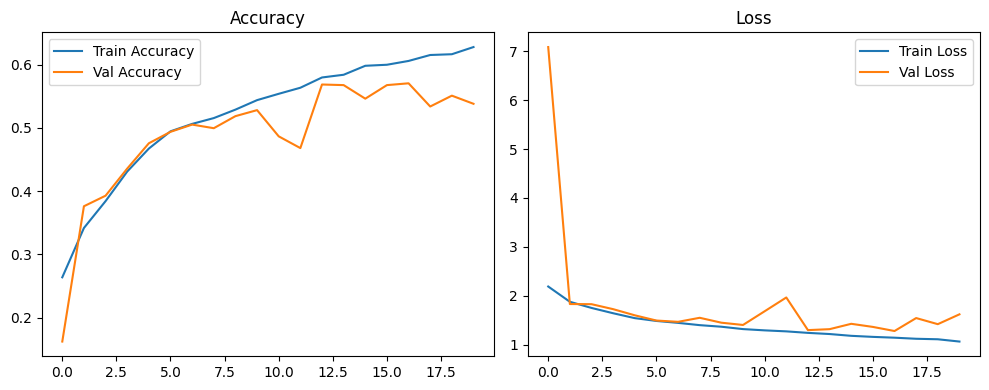

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi Performa Model

66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step


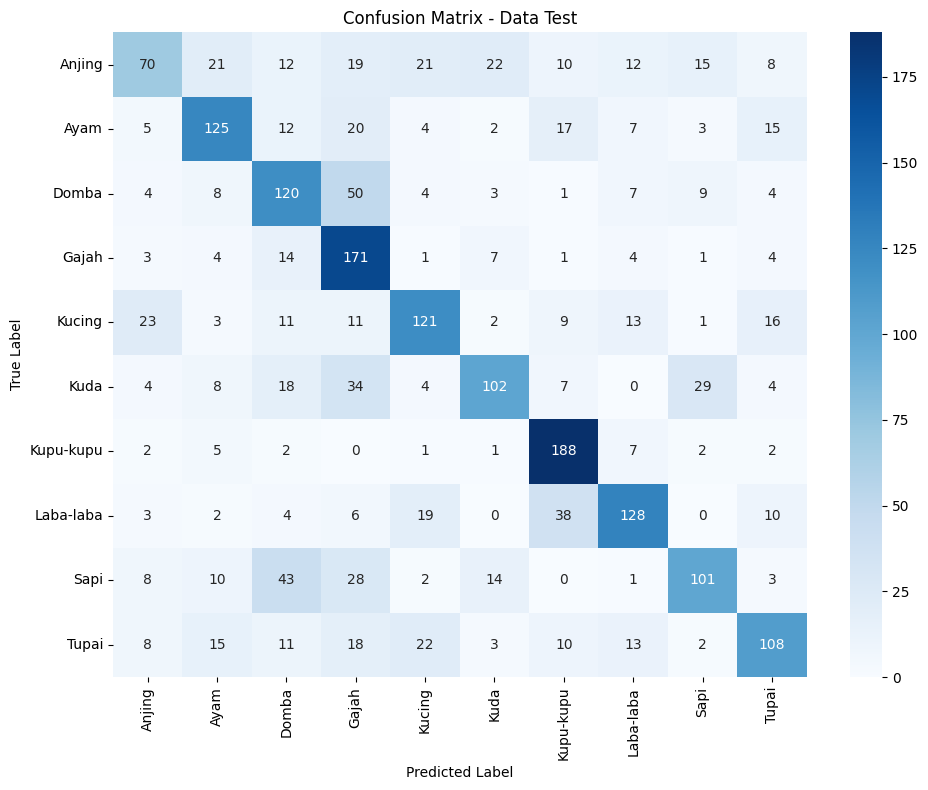

              precision    recall  f1-score   support

      Anjing       0.54      0.33      0.41       210
        Ayam       0.62      0.60      0.61       210
       Domba       0.49      0.57      0.53       210
       Gajah       0.48      0.81      0.60       210
      Kucing       0.61      0.58      0.59       210
        Kuda       0.65      0.49      0.56       210
   Kupu-kupu       0.67      0.90      0.77       210
   Laba-laba       0.67      0.61      0.64       210
        Sapi       0.62      0.48      0.54       210
       Tupai       0.62      0.51      0.56       210

    accuracy                           0.59      2100
   macro avg       0.60      0.59      0.58      2100
weighted avg       0.60      0.59      0.58      2100



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Prediksi pada data test
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Ambil label kelas
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Data Test')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=False)
print(report)

# CNN Transfer Learning (MobileNetV2)

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load base MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # freeze layer awal (optional)

# 2. Tambahkan custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # 10 kelas Animals-10

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training Model

In [ ]:
# Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 162s 487ms/step - accuracy: 0.3579 - loss: 1.9475 - val_accuracy: 0.8948 - val_loss: 0.4092
Epoch 2/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 132s 430ms/step - accuracy: 0.8215 - loss: 0.5944 - val_accuracy: 0.9267 - val_loss: 0.2560
Epoch 3/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 128s 417ms/step - accuracy: 0.8806 - loss: 0.3676 - val_accuracy: 0.9381 - val_loss: 0.2103
Epoch 5/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 126s 410ms/step - accuracy: 0.8984 - loss: 0.3282 - val_accuracy: 0.9390 - val_loss: 0.2005
Epoch 6/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 127s 412ms/step - accuracy: 0.9008 - loss: 0.3080 - val_accuracy: 0.9362 - val_loss: 0.2011
Epoch 7/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 128s 416ms/step - accuracy: 0.9047 - loss: 0.3114 - val_accuracy: 0.9386 - val_loss: 0.1913
Epoch 8/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 128s 416ms/step - accuracy: 0.9056 - loss: 0.2964 - val_accuracy: 0.9419 - val_loss: 0.1873
Epoch 9/25
307/307 ━━━━━━━━━━━━━━━━━━━━ 128s 416ms/step - accuracy: 0.9092 -

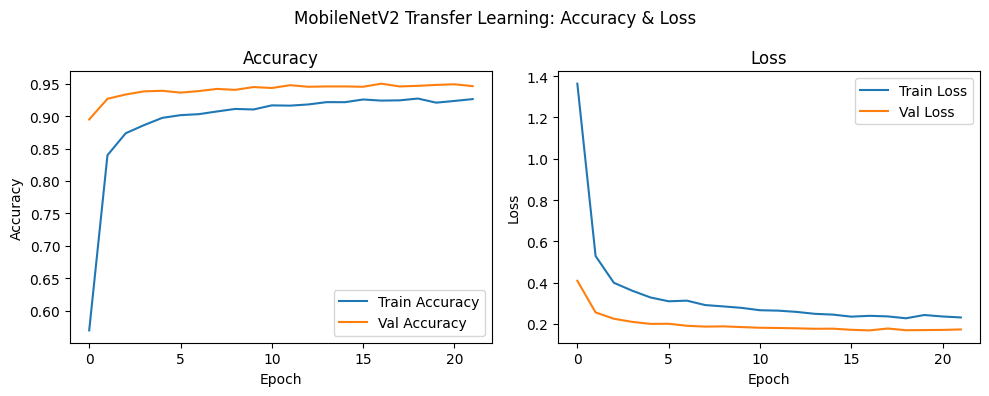

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("MobileNetV2 Transfer Learning: Accuracy & Loss")
plt.tight_layout()
plt.show()

# Evaluasi Model MobileNetV2

66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step


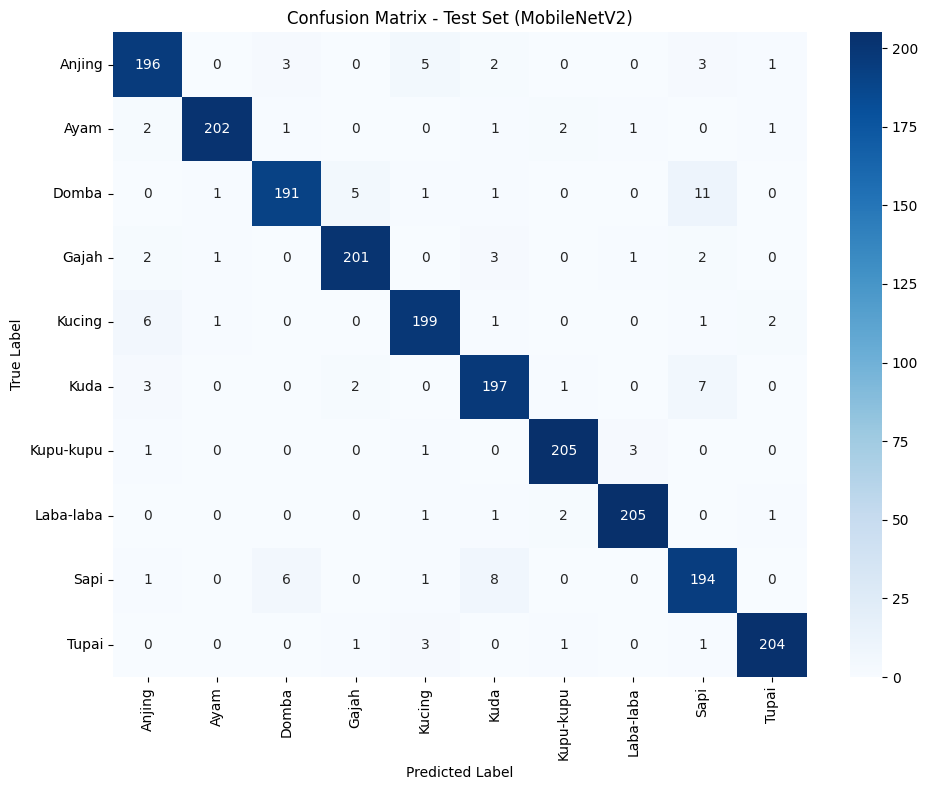

              precision    recall  f1-score   support

      Anjing       0.93      0.93      0.93       210
        Ayam       0.99      0.96      0.97       210
       Domba       0.95      0.91      0.93       210
       Gajah       0.96      0.96      0.96       210
      Kucing       0.94      0.95      0.95       210
        Kuda       0.92      0.94      0.93       210
   Kupu-kupu       0.97      0.98      0.97       210
   Laba-laba       0.98      0.98      0.98       210
        Sapi       0.89      0.92      0.90       210
       Tupai       0.98      0.97      0.97       210

    accuracy                           0.95      2100
   macro avg       0.95      0.95      0.95      2100
weighted avg       0.95      0.95      0.95      2100



In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prediksi pada data test
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set (MobileNetV2)')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Save Model

In [17]:
# Simpan sebagai .h5
model.save("animals10_mobilenetv2.h5")

In [18]:
# Simpan sebagai .tflite
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("animals10_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpssii563_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137440125434384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028990672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028997200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440125421136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440125423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028993360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028993936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028999504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028993744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137440028995664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1374400289

W0000 00:00:1750159164.098365      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750159164.098420      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750159164.240370      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [19]:
# Simpan sebagai TensorFlow SavedModel
tf.saved_model.save(model, "animals10_saved_model")

In [21]:
with open("requirements.txt", "w") as f:
    f.write("""
tensorflow>=2.12
gradio
numpy
pandas
matplotlib
seaborn
scikit-learn
Pillow
""")

In [22]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 32.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.7 MB/s eta 0:00:00
